# Pattern and Anomaly Mining in Large-scale, Evolving Graphs

This tutorial explores pattern mining in evolving graphs (networks), with a focus on anomaly detection. We will explore different statistics that can be computed on patterns, such as frequency and persistence, and their relationships. 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from collections import defaultdict
import sys
import random
from sklearn.neighbors import KDTree
sys.path.append('../src/')
'''
Below this are imports of custom code for this tutorial.
'''
from stream import Stream
from oPENminer import oPENminer
from plotter import Plotter
from output_reader import OutputReader

We built a wrapper around Matplotlib with some basic functionality for specific plots that we'll need.
See `src/plotter.py` if you are interested. We also initialize a few colors that we'll use throughout.

In [7]:
plotter = Plotter()
gray = (0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.2) # 0.2 alpha gray
black = '#000000'
blue = '#377eb8'
orange = 'coral'

### Transportation Networks

We'll start with transportation networks. These can encode many different types of information, but we will focus on traffic, as this evolves rapidly. Thus an edge (u, v) in a network means that a vehicle is currently traveling from some location u to some other location v. 

Our first network will be a network of bike share traffic in Columbus, OH. Each node is a bike station from which people can rent bikes.

Since once a bike trip is complete the rider leaves the bike, sequences of edges are not linked.
Thus, we set the maximum snippet size to, so that each activity snippet corresponds to a single bike trip.

In [48]:
stream_name = 'columbus_bike'
# a class to feed edge-updates to PENminer
stream = Stream('columbus_bike')
# PENminer (the 'o' at the beginning is for offline analysis;
# there is also sPENminer if we wanted to analyze a network evolving in real-time)
method = oPENminer(stream,
                   window_size=1,
                   max_size=1,
                   view='id',
                   alpha=2.0,
                   beta=0.5,
                   gamma=3.0,
                   save_output=True,
                   save_occs=True)

Now let's run PENminer to compute the frequency and persistence of each snippet.

In [49]:
method.mine()

10000 edge updates processed.
20000 edge updates processed.
30000 edge updates processed.
40000 edge updates processed.
50000 edge updates processed.
60000 edge updates processed.
70000 edge updates processed.
80000 edge updates processed.
90000 edge updates processed.
100000 edge updates processed.
110000 edge updates processed.
120000 edge updates processed.
130000 edge updates processed.
140000 edge updates processed.
150000 edge updates processed.
160000 edge updates processed.
170000 edge updates processed.
180000 edge updates processed.
190000 edge updates processed.
200000 edge updates processed.
210000 edge updates processed.
220000 edge updates processed.
230000 edge updates processed.
240000 edge updates processed.
250000 edge updates processed.
260000 edge updates processed.
270000 edge updates processed.
280000 edge updates processed.
290000 edge updates processed.
300000 edge updates processed.
310000 edge updates processed.
320000 edge updates processed.
330000 edge updat

The output goes to various files in `output/offline/id/`. If you wish, you can look there to see what exactly it outputs (see the last line of the output for the exact file prefix), but this is unecessary. We built a class that handles reading the output for easy analysis. 

Run the next cell to load the output you just generated.

In [50]:
output_reader = OutputReader(stream_name, 
                             offline_online='offline', 
                             window_size=method.window_size, 
                             max_size=method.max_size, 
                             view=method.view,
                             alpha=method.alpha,
                             beta=method.beta, 
                             gamma=method.gamma)

The output of PENminer is the frequency and persistence of each snippet that appeared in the network over time. Let's start by looking at the relationship between frequency and persistence.

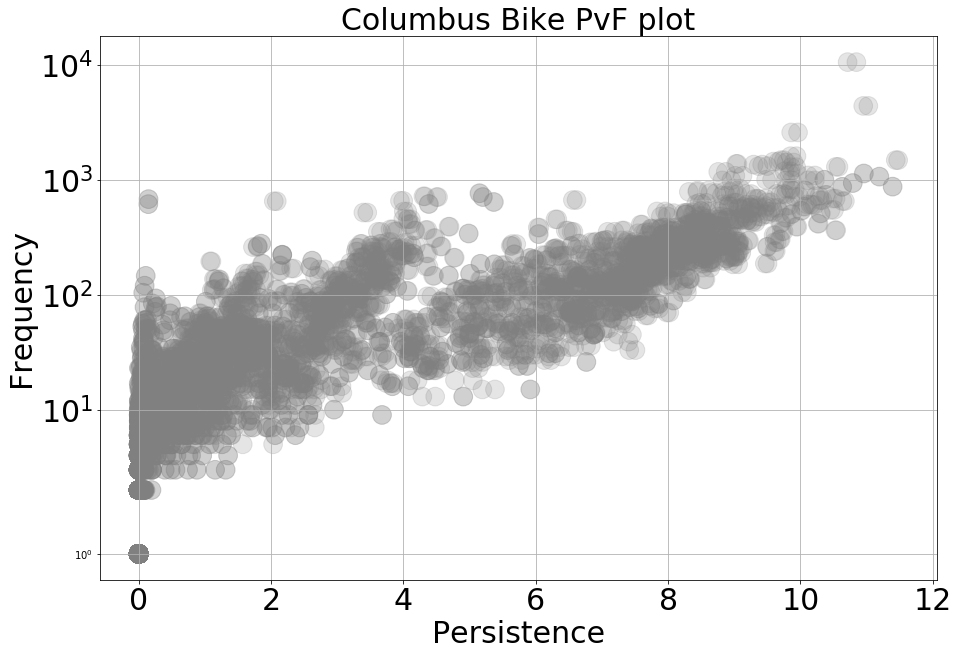

In [51]:
P_scores = list()
F_scores = list()
colors = list()
for snippet in output_reader.patterns:
    P = output_reader.P(snippet)
    F = output_reader.F(snippet)
    P_scores.append(P)
    F_scores.append(F)
    colors.append(gray)
plotter.x_vs_y(x=P_scores, 
               y=F_scores,
               title='Columbus Bike PvF plot',
               yscale='symlog',
               xlabel='Persistence',
               ylabel='Frequency',
               dpi=250,
               size=350,
               colors=colors,
               transparent=True)

Some positive correlation is visible, as would likely be expected, since frequency is one component of persistence. 
This cloud of points in and of itself might not be very informative. Let's dig into some of the specific points to learn more.

We'll find some anomalies (i.e., outliers) in the PvF plot. To do so, we'll use a simple anomaly detection approach: average KNN. This approach gives a point, `x`, an anomaly score equal to the average Euclidean distance from its k-nearest-neighbors. 

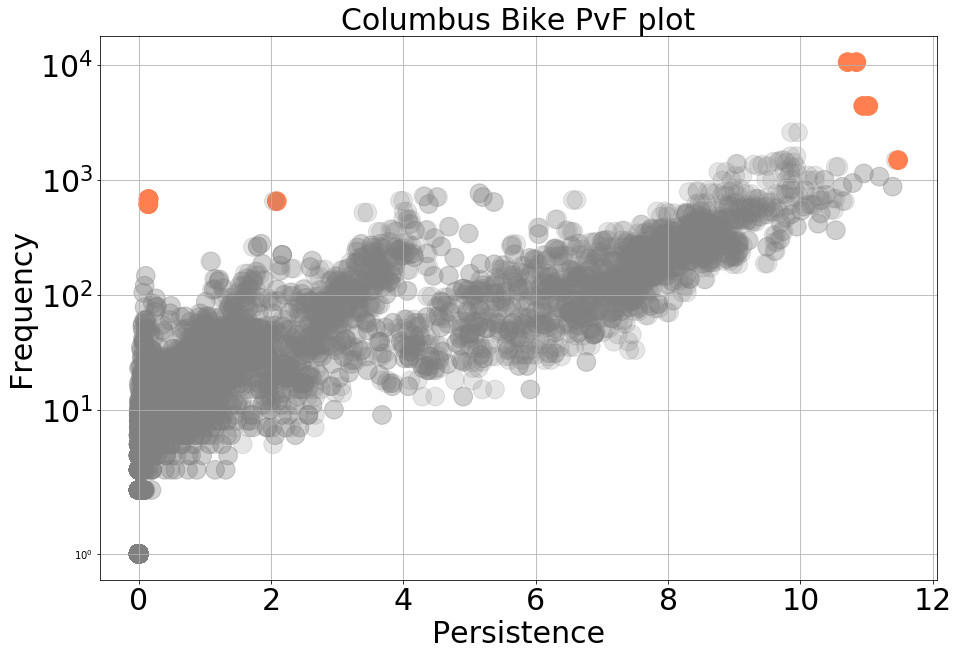

In [52]:
# X is an n x 2 matrix, where each row corresponds to a snippet, the 1st column is its persistence, and the 2nd its frequency
X = list()
id_to_snippet = dict()
for i, snippet in enumerate(output_reader.patterns):
    id_to_snippet[i] = snippet
    P = output_reader.P(snippet)
    F = output_reader.F(snippet, _log=True)
    X.append((P, F))
X = np.asarray(X)

# c.f. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html
# A KDTree is a data structure for efficient near-neighbor search.
kdtree = KDTree(X)
k = 10
# The matrix D will be the distance from each point to its k-nearest-neighbors.
# The function includes the point itself as a neighbor, so we use k + 1 and will skip the nearest neighbor (trivially the point itself)
D, _ = kdtree.query(X, k=k + 1)
# we now map each snippet to its anomaly score
snippet_to_anom_score = dict()
for i, d in enumerate(D):
    # the anomaly score of each snippet is the average distance to its k nearest neighbors
    snippet_to_anom_score[id_to_snippet[i]] = np.mean(d[1:])

# we'll visualize the 10 most anomalous points in coral (orange)
top_k = set(it[0] for it in sorted(snippet_to_anom_score.items(), reverse=True, key=lambda it: it[-1])[:10])

# generate the points for Matplotlib
P_scores = list()
F_scores = list()
colors = list()
for snippet in output_reader.patterns:
    P = output_reader.P(snippet)
    F = output_reader.F(snippet)
    P_scores.append(P)
    F_scores.append(F)
    if snippet in top_k:
        colors.append('coral')
    else:
        colors.append((0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.2)) # 0.2 alpha gray    
        
# generate the plot 
plotter.x_vs_y(x=P_scores, 
               y=F_scores,
               title='Columbus Bike PvF plot',
               yscale='symlog',
               xlabel='Persistence',
               ylabel='Frequency',
               dpi=250,
               size=350,
               colors=colors,
               transparent=True)

Now that we have found some anomalies, let's look at the timeline of some of them to see whatsorts of timelines each region corresponds to. For reference, we'll also show some points in the middle of the PvF plot.

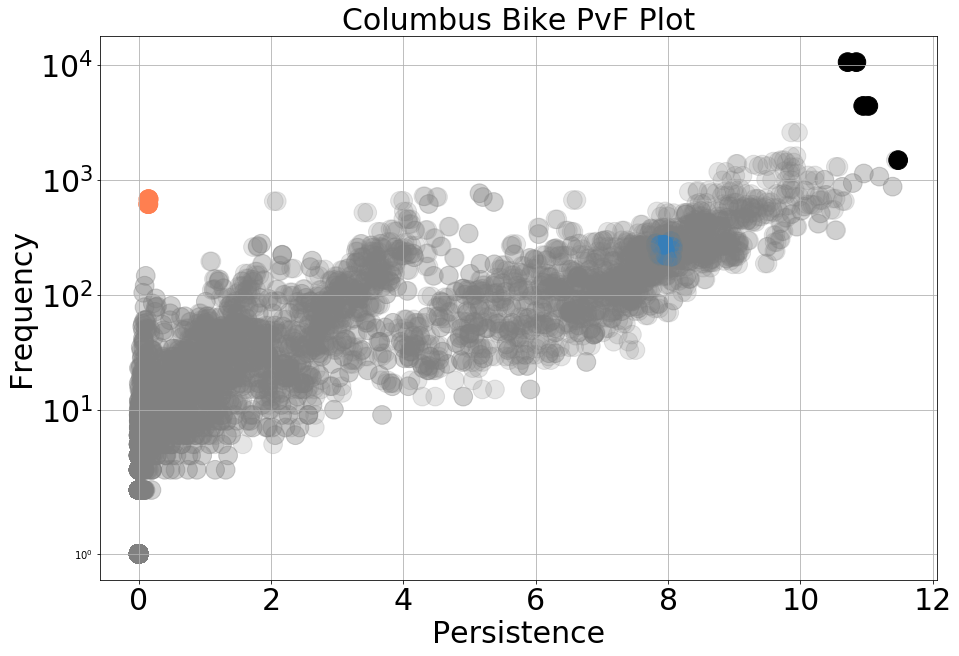

In [53]:
P_scores = list()
F_scores = list()
X = list()
colors = list()
for snippet in output_reader.patterns:
    P = output_reader.P(snippet)
    F = output_reader.F(snippet)
    P_scores.append(P)
    F_scores.append(F)
    X.append([P, output_reader.F(pattern, _log=True)])
    if snippet in top_k and P > 10.5: # These will be the super persistent snippets (like the outliers on the right)
        colors.append(black)
    elif snippet in top_k and P < 1.0 and 500 < F: # these are like the outliers on the left 
        colors.append(orange)
    elif 7.8 < P < 8.1 and 210 < F < 300: # these will be snippets in the middle of the plot for reference
        colors.append(color_blue) # theme blue
    else:
        colors.append((0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.2)) # 0.2 alpha gray
X = np.asarray(X)

plotter.x_vs_y(x=P_scores, 
               y=F_scores,
               title='Columbus Bike PvF Plot',
               yscale='symlog',
               xlabel='Persistence',
               ylabel='Frequency',
               dpi=250,
               size=350,
               colors=colors,
               transparent=True)

Next, we'll plot three timelines—one from each colored region—chosen arbitrarily.

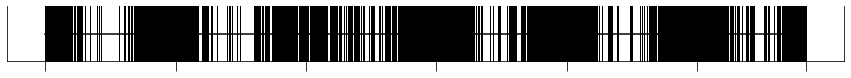

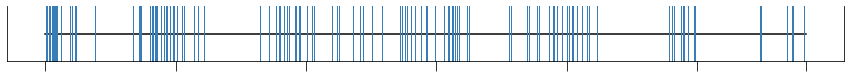

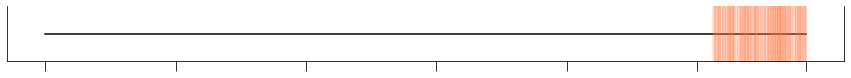

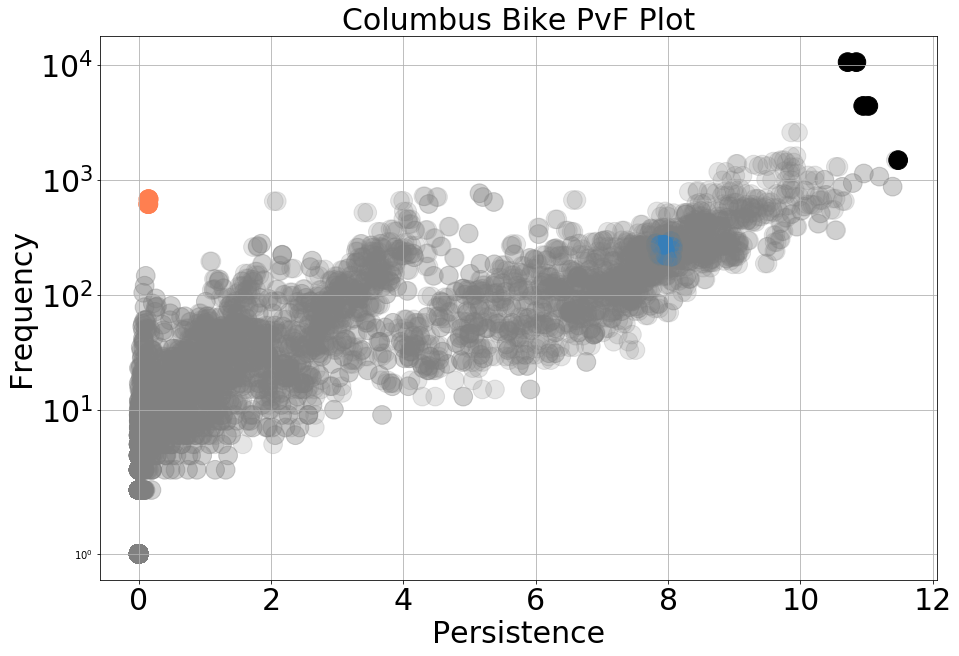

In [74]:
'''
The three snippets hand-picked by visualy inspecting the PvF plot.
'''
output_reader.load_occs({'1_Bicentennial Park_Bicentennial Park_0',
                         '1_Front St & Town St_Lucas St & Town St_0',
                         '1_Bicentennial Park_Bank St & Frankfort St_0'})
t = output_reader.te - output_reader.ts + 1
for pattern, occs in output_reader.pattern_to_occs.items():
    P = output_reader.P(pattern)
    F = output_reader.F(pattern)
    if pattern == '1_Bicentennial Park_Bicentennial Park_0':
        plotter.timeline(occs,
                         ts=1,
                         te=t,
                         t=t,
                         xlabel='',
                         interval='Y',
                         alpha=1.0,
                         timeticksize=1,
                         color=black,
                         no_labels=True,
                         marker='line')
    elif pattern == '1_Front St & Town St_Lucas St & Town St_0':
        plotter.timeline(occs,
                         ts=1,
                         te=t,
                         t=t,
                         xlabel='',
                         interval='Y',
                         alpha=1.0,
                         timeticksize=0.1,
                         color=orange,
                         no_labels=True,
                         marker='line')
    elif pattern == '1_Bicentennial Park_Bank St & Frankfort St_0':
        plotter.timeline(occs,
                         ts=1,
                         te=t,
                         t=t,
                         xlabel='',
                         interval='Y',
                         alpha=1.0,
                         timeticksize=1,
                         color=blue,
                         no_labels=True,
                         marker='line')
        
# replot the PvF plot just for reference
plotter.x_vs_y(x=P_scores, 
               y=F_scores,
               title='Columbus Bike PvF Plot',
               yscale='symlog',
               xlabel='Persistence',
               ylabel='Frequency',
               dpi=250,
               size=350,
               colors=colors,
               transparent=True)

### Social Networks

Now let's move on to social networks and do similar analysis. Social networks capture activity among users and/or content. In our case, we'll focus on Stackoverflow, which consists of interactions among users. The interactions are between users, and
can be answers to questions, comments on questions, or comments on answers.

In [2]:
stream_name = 'stackoverflow'
stream = Stream(stream_name)
method = oPENminer(stream,
                   window_size=3600,
                   max_size=3,
                   view='id',
                   alpha=1.0,
                   beta=0.5,
                   gamma=2.0,
                   save_output=True,
                   save_occs=True)

Go ahead and mine this network.

In [3]:
method.mine()

10000 edge updates processed.
20000 edge updates processed.
30000 edge updates processed.
40000 edge updates processed.
50000 edge updates processed.
60000 edge updates processed.
70000 edge updates processed.
80000 edge updates processed.
90000 edge updates processed.
100000 edge updates processed.
110000 edge updates processed.
120000 edge updates processed.
130000 edge updates processed.
140000 edge updates processed.
150000 edge updates processed.
160000 edge updates processed.
170000 edge updates processed.
180000 edge updates processed.
190000 edge updates processed.
200000 edge updates processed.
210000 edge updates processed.
220000 edge updates processed.
230000 edge updates processed.
240000 edge updates processed.
250000 edge updates processed.
260000 edge updates processed.
270000 edge updates processed.
280000 edge updates processed.
290000 edge updates processed.
300000 edge updates processed.
310000 edge updates processed.
320000 edge updates processed.
330000 edge updat

Load the output.

In [4]:
output_reader = OutputReader(stream_name, 
                             offline_online='offline', 
                             window_size=method.window_size, 
                             max_size=method.max_size, 
                             view=method.view,
                             alpha=method.alpha,
                             beta=method.beta, 
                             gamma=method.gamma)

This graph is pretty big, so we are going to filter out some of the snippets with both very low persistence and and frequency to allow this to run on a laptop.

In [5]:
random.seed(0)
idx = 0
# covered snippets will be the ones we keep
covered_snippets = set()
for pattern in output_reader.patterns:
    P = output_reader.P(pattern)
    if P > 1.0 or (P > 0.1 and random.randint(0, 9) == 0) or random.randint(0, 149) == 0:
        F = output_reader.F(pattern)
        covered_snippets.add(pattern)

We are going to demonstrate a different simple approach to detecting anomalies: a density-based approach. We'll generate a set of uniform bins for both frequency and persistence. When these cross each other in the PvF plot, they form a grid, and each point will fall in one cell in the grid. The anomaly score for a point `x` will be the number of other points in the grid (fewer = more anomalous).

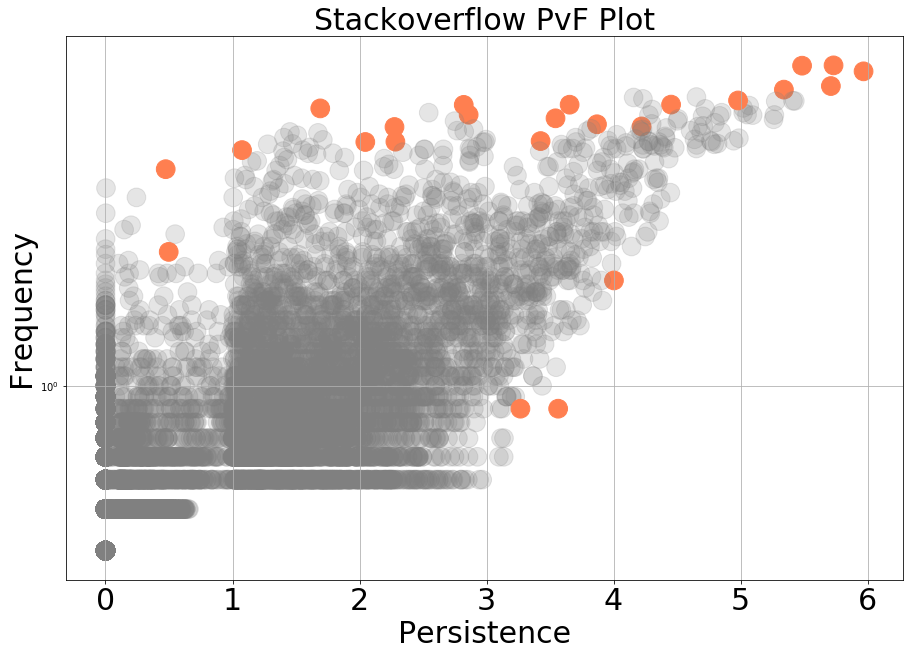

In [8]:
# compute the maximum F and P values
max_F = max(np.log10(np.asarray(list(output_reader.pattern_to_F.values())) + 1))
max_P = max(output_reader.pattern_to_P.values())
# compute the corresponding bins at intervals of 0.25
bins_P = np.arange(0, max_P + 1, 0.25)
bins_F = np.arange(0, max_F + 1, 0.25)

# count the number of snippets in each cell
cell_to_count = defaultdict(int)
for snippet in covered_snippets:
    P = output_reader.P(snippet)
    F = output_reader.F(snippet, _log=True)
    b1 = int(np.digitize(P, bins_P))
    b2 = int(np.digitize(F, bins_F))
    cell_to_count[(b1, b2)] += 1
    
# compute the anomaly scores for each snippet
P_scores = list()
F_scores = list()
colors = list()
for snippet in covered_snippets:
    P = output_reader.P(snippet)
    F = output_reader.F(snippet, _log=True)
    b1 = int(np.digitize(P, bins_P))
    b2 = int(np.digitize(F, bins_F))
    P_scores.append(P)
    F_scores.append(F)
    # in our case here, we'll mark all the points that landed in a cell on their own as anomalies
    if cell_to_count[(b1, b2)] == 1:
        colors.append('coral')
    else:
        colors.append((0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.2)) # 0.2 alpha gray    
        
# plot the anomalies
plotter.x_vs_y(x=P_scores, 
               y=F_scores,
               title='Stackoverflow PvF Plot',
               yscale='symlog',
               xlabel='Persistence',
               ylabel='Frequency',
               dpi=350,
               size=350,
               colors=colors)

Once again, we'll pick three snippets to zoom in on; two outliers and one from the center of the plot.

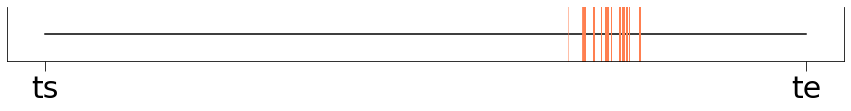

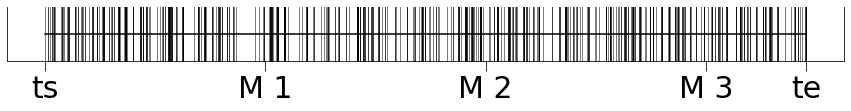

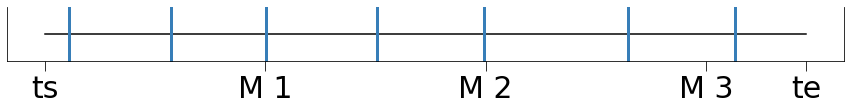

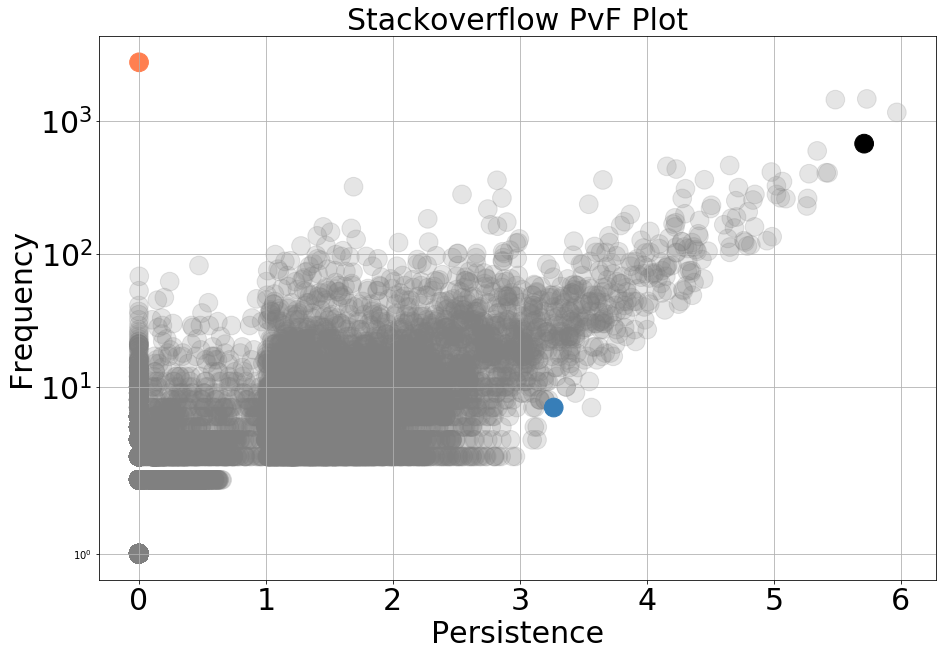

In [10]:
'''
Three snippets hand-picked by visualy inspecting the PvF plot.
'''
output_reader.load_occs({'1_23354_23354_commented_on_a',
                         '1_72603_82199_commented_on_a|1_72603_82199_commented_on_a|1_72603_82199_commented_on_a',
                         '1_1950_55747_answered'})
t = output_reader.te - output_reader.ts + 1
random.seed(0)
P_scores = list()
F_scores = list()
colors = list()
for pattern in covered_snippets.union({'1_23354_23354_commented_on_a',
                         '1_72603_82199_commented_on_a|1_72603_82199_commented_on_a|1_72603_82199_commented_on_a',
                         '1_1950_55747_answered'}):
    P = output_reader.P(pattern)
    F = output_reader.F(pattern)
    P_scores.append(P)
    F_scores.append(F)
    if pattern == '1_23354_23354_commented_on_a':
        colors.append(black)
        occs = output_reader.occs(pattern)
        plotter.timeline(occs,
                         ts=1,
                         te=t,
                         t=t,
                         xlabel='',
                         interval='M',
                         alpha=0.5,
                         timeticksize=1,
                         color=black,
                         marker='line')
    elif pattern == '1_72603_82199_commented_on_a|1_72603_82199_commented_on_a|1_72603_82199_commented_on_a':
        colors.append(orange)
        occs = output_reader.occs(pattern)
        plotter.timeline(occs,
                         ts=1 + (86400 * 9 + 50000), # zoom in
                         te=t - (86400 * 95 + 10000), # zoom in
                         t=t,
                         xlabel='',
                         interval='M',
                         alpha=0.5,
                         timeticksize=1,
                         color=orange,
                         marker='line')
    elif pattern == '1_1950_55747_answered':
        colors.append(blue)
        occs = output_reader.occs(pattern)
        plotter.timeline(occs,
                         ts=1,
                         te=t,
                         t=t,
                         xlabel='',
                         interval='M',
                         alpha=1.0,
                         timeticksize=3,
                         color=blue,
                         marker='line')
    else:
        colors.append(gray)
        
plotter.x_vs_y(x=P_scores, 
               y=F_scores,
               title='Stackoverflow PvF Plot',
               yscale='symlog',
               xlabel='Persistence',
               ylabel='Frequency',
               dpi=350,
               size=350,
               colors=colors)

The bursty anomaly (orange) reveals users u72603 and u82199 (anonymized ids) commenting on u82199’s answer 36 times over the course of 1hr in the 3-month interval, then never interacting again. The timeline we plotted is zoomed in on for clarity. The most persistent snippets (one shown in black) are users commenting on their own answers, suggesting that it is unusual for the same two distinct users to interact persistently over time. On the other hand, the subtly persistent anomaly (blue) reveals u1950 regularly answering u55747’s questions.

### Scalability